### in residual vector quantized VAEs , we have multiple codebooks.This lowers the loss of precision due to quantization. In normal VQVAEs , the quantized vector is passed to the decoder and the loss of precision is the difference between the quantized and the encoded one. In Residual VQVAEs , the residual i.e the first loss is passed to successive qunatizers which quantize the residuals. At last all the quantizations are added and then passed to the decoder.

In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms

train_set  = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_set  = torchvision.datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=128,shuffle=False)

In [ ]:
# implementing vector quantizer
import torch.nn as nn
import torch
class VectorQuantizer(nn.Module):

  def __init__(self,codebook_size, embeddding_dim):
    super().__init__()

    self.embedding = nn.Embedding(codebook_size, embeddding_dim)
    self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)

    self.codebook_size = codebook_size
    self.embedding_dim = embeddding_dim

  def forward(self,x, efficient=True):

    if not efficient:
      # x -> (B,L)
      # emb -> (C, L)
      # we want each sample in the batch to undergo operation with entire embedding matrix.
      # so we reshape the x and q as . x -> (B,1,L) and q-> (B,C,L)
      z = x.unsqueeze(1)
      batch_size = x.shape[0]
      emb = self.embedding.weight.unsqueeze(0).repeat(batch_size,1,1)
      distance = torch.sum((z - emb)**2,dim=-1)
      return distance

    else:

      # we need to do (x-emb)**2  , which is x**2 - 2*x*emb + emb**2

      x2 = torch.sum(x**2, dim = -1,keepdim=True)
      emb2 = torch.sum(self.embedding.weight **2 ,dim = -1).unsqueeze(0)
      xemb = torch.matmul(x,self.embedding.weight.transpose(-2,-1))
      distance = x2 - 2*xemb + emb2

    closest = torch.argmin(distance, dim=-1)

    # we can now take the closest latents (quantized latents) directly with embedding matrix by passing in the indices

    qunatized_latents = self.embedding(closest)
    return qunatized_latents, closest


vq = VectorQuantizer(6,2)
x = torch.randn((4,2))
out,indexes = vq(x)
print(out.shape,indexes.shape)
print(out,indexes)

torch.Size([4, 2]) torch.Size([4])
tensor([[-0.0421,  0.0774],
        [ 0.1576, -0.1313],
        [ 0.1576, -0.1313],
        [-0.0421,  0.0774]], grad_fn=<EmbeddingBackward0>) tensor([3, 4, 4, 3])


In [ ]:
import numpy as np

class Linearresidualvqvae(nn.Module):
  def __init__(self,latent_dim=2,codebook_size=64,num_codebooks=4):
    super().__init__()

    self.latent_dim = latent_dim
    self.codebook_size = codebook_size
    self.num_codebooks = num_codebooks

    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,latent_dim)
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28)
    )

    self.rvq = nn.ModuleList(
        [VectorQuantizer(self.codebook_size,self.latent_dim) for _ in range(num_codebooks)]
    )

  def forward_enc(self,x):
    return self.encoder(x)

  def forward_rvq(self,z):

    codes_indexes = []
    codebook_loss = 0
    commitment_loss = 0

    final_pre_dec = torch.zeros_like(z, device=z.device)

    for rvq in self.rvq:

      code,index = rvq(z)
      codes_indexes.append(index)

      codebook_loss = torch.mean((code - z.detach())**2)
      commitment_loss = torch.mean((code.detach())**2)

      codebook_loss += codebook_loss
      commitment_loss += commitment_loss

      codes = z + (code - z).detach()

      final_pre_dec += code

      # calculate residual
      z = z - code.detach()

    codes_indexes = torch.stack(codes_indexes,dim=-1)

    return final_pre_dec,codebook_loss, commitment_loss,codes_indexes

  @torch.no_grad() # only needed during inference
  def get_codes_index(self,x):
    x = x.flatten(1)
    z = self.forward_enc(x)
    *_, codes_indexes = self.forward_rvq(z)
    return codes_indexes


  @torch.no_grad()
  def reconstruct_from_codes_indexes(self,x):

    batch_size = x.shape[0]

    final_pre_dec = torch.zeros(x.shape[0],self.latent_dim,device=x.device)

    for idx,quantizer in enumerate(self.rvq):

      codes_index = x [:,idx]
      codes = quantizer.embedding(codes_index)
      final_pre_dec += codes


    decoded = self.decoder(final_pre_dec)
    decoded = decoded.reshape(batch_size, 1, 28, 28)
    return decoded

  def forward_dec(self,x):

    codes,codebook_loss, commitment_loss,codes_indexes = self.forward_rvq(x)
    decoded=  self.decoder(codes)
    return codes, decoded, codebook_loss, commitment_loss

  def forward(self,x):
    batch_size,channel,height,width = x.shape
    x = x.flatten(1)

    z = self.forward_enc(x)

    codes,decoded,codebook_loss,commitment_loss = self.forward_dec(z)
    decoded = decoded.reshape(-1,channel,28,28)

    return z,codes,decoded,codebook_loss,commitment_loss

linear_rvqvae = Linearresidualvqvae()
x = torch.randn((4,1,28,28))
linear_rvqvae(x)

(tensor([[ 0.0254,  0.1030],
         [ 0.0382,  0.0725],
         [ 0.0547, -0.0607],
         [ 0.1237,  0.0662]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.0126,  0.0608],
         [ 0.0334,  0.0552],
         [ 0.0555, -0.0568],
         [ 0.0567,  0.0475]], grad_fn=<AddBackward0>),
 tensor([[[[-0.0893, -0.0839,  0.0497,  ..., -0.0319,  0.2164, -0.0457],
           [-0.0139,  0.0797, -0.1158,  ...,  0.2352, -0.0672, -0.0793],
           [-0.0144,  0.0066,  0.0578,  ...,  0.2247,  0.2316,  0.0325],
           ...,
           [ 0.1283, -0.0383, -0.0629,  ..., -0.0430,  0.0078, -0.0120],
           [ 0.0479, -0.0255, -0.0792,  ..., -0.1857,  0.1546, -0.0806],
           [-0.0647,  0.1046, -0.0184,  ..., -0.0405,  0.0455,  0.1006]]],
 
 
         [[[-0.0910, -0.0829,  0.0494,  ..., -0.0317,  0.2154, -0.0464],
           [-0.0128,  0.0800, -0.1170,  ...,  0.2355, -0.0667, -0.0795],
           [-0.0136,  0.0053,  0.0568,  ...,  0.2235,  0.2329,  0.0339],
           ...,
           [ 0.1288

In [ ]:
import tqdm as tqdm

def train(model,
          trainloader,
          testloader,
          batch_size,
          training_iterations,
          evaluation_iterations):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)



    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []
    train_losses = []
    evaluation_losses = []

    pbar = tqdm.tqdm(range(training_iterations))

    train = True

    step_counter = 0
    while train:

        for images, labels in trainloader:

            images = images.to(device)
            encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
            reconstruction_loss = torch.mean((images-decoded)**2)
            loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:

                model.eval()

                for images, labels in testloader:

                    images = images.to(device)

                    encoded, quantized_encoded, decoded, codebook_loss, commitment_loss, = model(images)
                    reconstruction_loss = torch.mean((images-decoded)**2)
                    loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss

                    evaluation_loss.append(loss.item())

                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)

                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)

            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])

    return model, train_losses, evaluation_losses

In [ ]:
linear_rvq = Linearresidualvqvae()
linear_rvqvae, train_losses, evaluation_losses = train(linear_rvq,
                                                   trainloader=train_loader,
                                                   testloader=test_loader,
                                                   batch_size=64,
                                                   training_iterations=2500,
                                                   evaluation_iterations=250)



  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 1/2500 [00:01<56:44,  1.36s/it]

  0%|          | 8/2500 [00:01<05:43,  7.25it/s]

  1%|          | 15/2500 [00:01<02:50, 14.59it/s]

  1%|          | 21/2500 [00:01<01:57, 21.01it/s]

  1%|          | 27/2500 [00:01<01:29, 27.49it/s]

  1%|▏         | 34/2500 [00:01<01:10, 35.03it/s]

  2%|▏         | 41/2500 [00:02<00:59, 41.67it/s]

  2%|▏         | 48/2500 [00:02<00:52, 46.78it/s]

  2%|▏         | 55/2500 [00:02<00:48, 50.60it/s]

  2%|▏         | 62/2500 [00:02<00:45, 53.20it/s]

  3%|▎         | 69/2500 [00:02<00:43, 55.92it/s]

  3%|▎         | 76/2500 [00:02<00:41, 57.81it/s]

  3%|▎         | 83/2500 [00:02<00:41, 58.87it/s]

  4%|▎         | 90/2500 [00:02<00:42, 56.36it/s]

  4%|▍         | 96/2500 [00:02<00:42, 56.98it/s]

  4%|▍         | 103/2500 [00:03<00:40, 58.56it/s]

  4%|▍         | 109/2500 [00:03<00:40, 58.92it/s]

  5%|▍         | 116/2500 [00:03<00:39, 60.11it/s]

  5%|▍         | 123/2500 [00:03<00:3

Completed Training!
Final Training Loss 0.0924336051940918
Final Evaluation Loss 0.0926292842324776


(1, 1, 28, 28)


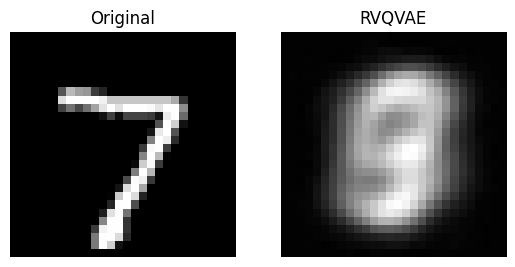

In [ ]:
import matplotlib.pyplot as plt

generated_index = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)


_,_,rvqvae_reconstructed,_, *_ = linear_rvqvae(image)

image = image.to("cpu")

rvqvae_reconstructed = rvqvae_reconstructed.to("cpu").detach().numpy()
print(rvqvae_reconstructed.shape)
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")


ax[1].imshow(rvqvae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("RVQVAE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")


plt.show()

tensor([[1, 1, 3, 4]], device='cuda:0')
torch.Size([1, 1, 28, 28])


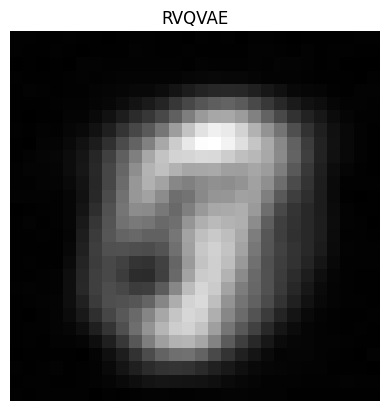

In [ ]:
# generating with codes

sample_index = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)

# get codes index
codes_index = linear_rvqvae.get_codes_index(image)
print(codes_index)

# decoding from index
reconstructed_image = linear_rvqvae.reconstruct_from_codes_indexes(codes_index)
print(reconstructed_image.shape)

plt.imshow(rvqvae_reconstructed.squeeze(), cmap="gray")
plt.title("RVQVAE")
plt.axis("off")
plt.show()